In [168]:
import argparse
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime


from dataset import get_dataloader
from tqdm import tqdm
import random
from models.gated_tpp import *
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

## Kernel Predictions

In [204]:
def power_law_kernel(t):  
    
    return 0.2 * (0.5 + t)**(-1.3)

data = '../data/simulated/power_hawkes/'
batch_size = 1
def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)

train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')


trainloader = get_dataloader(train_data, batch_size, shuffle=True)
testloader = get_dataloader(test_data,1, shuffle=False)
valloader = get_dataloader(dev_data, 1, shuffle=False)

t_max = max(max(max(valloader.dataset.time)), max(max(testloader.dataset.time)), max(max(trainloader.dataset.time)))

model = gated_TPP(num_types,32, t_max=t_max,dropout= 0.1)
device = 'cuda'
model.load_state_dict(torch.load('trained_models/power_hawkesdebug_model.pt'))

type_emb=model.encoder.type_emb.weight* math.sqrt(model.d_model)
length_scale  =model.encoder.kernel.length_scale(type_emb)[-1]
s,l = model.encoder.sigmoid.params(model.encoder.type_emb.weight)[-1]
print(f'Length Scale: {length_scale.item():.4f}, Gate Param s: {s:.4f}, Gate Param l: {l:.4f}')

Length Scale: 1.8963, Gate Param s: 0.5655, Gate Param l: 0.2532


In [172]:
kernel_values = []
all_times = []

model = model.to(device)

for batch in testloader:
    
    event_type = batch[2]
    length = event_type.sum()
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)
    scores, embedding,t_diff = model.encoder(event_type,event_time)
    scores = model.encoder.scores
        
    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]
    
    kernel_values.append(triggering_values.detach())
    all_times.append(times.detach())
    
kernel_values = torch.cat(kernel_values)
all_times = torch.cat(all_times)

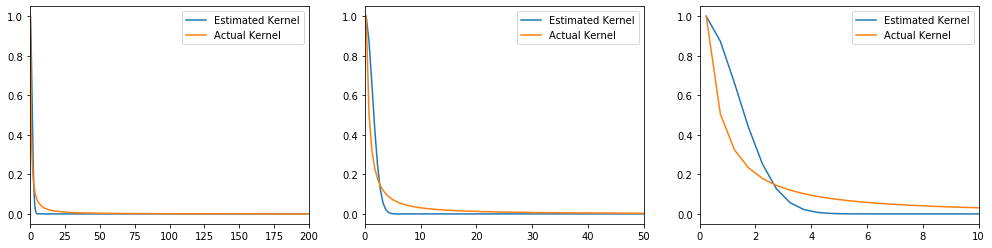

In [173]:
x = all_times.detach()
y = kernel_values.detach()

sorted_indices = torch.argsort(x)

x = x[sorted_indices]
y = y[sorted_indices]


## Moving Average

step = 0.5

t = []
alpha = []

for i in np.arange(step,200,step):
    avg_index = (x<i) & ( x >i - step)
    t.append(x[avg_index].mean().item())
    alpha.append(y[avg_index].mean().item())
alpha = np.array(alpha)
alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
actual_alpha = power_law_kernel(np.array(t))
actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

ax1.plot(t,alpha,label='Estimated Kernel')
ax1.plot(t,actual_alpha,label='Actual Kernel')
ax1.set_xlim(0, 200)
ax1.legend()

ax2.plot(t,alpha,label='Estimated Kernel')
ax2.plot(t,actual_alpha,label='Actual Kernel')
ax2.set_xlim(0, 50)
ax2.legend()


ax3.plot(t,alpha,label='Estimated Kernel')
ax3.plot(t,actual_alpha,label='Actual Kernel')
ax3.set_xlim(0, 10)
ax3.legend()

plt.show()

In [189]:
torch.clone(model.encoder)

TypeError: clone(): argument 'input' (position 1) must be Tensor, not Encoder

In [202]:
def power_law_kernel(t):  
    
    return 0.2 * (0.5 + t)**(-1.3)


def get_moving_average(times,scores,step = 0.15,max_t = 200):
    
    t = []
    alpha = []
    
    index= 0
    for i in np.arange(step,max_t,step):
        avg_index = (x<i) & ( x >i - step)
        t.append(x[avg_index].mean().item())
        alpha.append(y[avg_index].mean().item())
    
    zero_avg_index = x ==0
    t.insert(0,x[zero_avg_index].mean().item())
    alpha.insert(0,y[zero_avg_index].mean().item())
    
    
    return np.array(t),np.array(alpha) 


def get_triggering_kernel_values(model,device ='cpu'):
    
    encoder = model.encoder.to(device)

    normalized_event_time = torch.arange(0,200,0.1).unsqueeze(0).to(device)
    event_type = torch.ones(normalized_event_time.size(-1)).long().unsqueeze(0).to(device)

    type_embedding = encoder.type_emb(event_type) * math.sqrt(model.d_model)

    subsequent_mask = get_subsequent_mask(event_type)

    xt_bar = normalized_event_time.unsqueeze(1). \
        expand(normalized_event_time.size(0), normalized_event_time.size(1), normalized_event_time.size(1))
    xt = xt_bar.transpose(1, 2)


    xd_bar = type_embedding.unsqueeze(1).expand(type_embedding.size(
        0), type_embedding.size(1), type_embedding.size(1), type_embedding.size(-1))
    xd = xd_bar.transpose(1, 2)


    scores = encoder.kernel((xt, xt_bar), (xd, xd_bar))* (encoder.sigmoid((xt, xt_bar), (xd, xd_bar)))

    length = event_type.sum()
    t_diff = torch.abs(xt - xt_bar)


    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]

    x = times.detach()
    y = triggering_values.detach()

    sorted_indices = torch.argsort(x)

    x = x[sorted_indices]
    y = y[sorted_indices]
    
    return x,y



def plot_triggering_kernel_vs_actual_kernels(model,kernel_function,device = 'cpu',step = 0.25 ):
    
    times, scores = get_triggering_kernel_values(model,device = 'cpu')
    t,alpha = get_moving_average(times,scores,step = step)
    
    
    alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
    actual_alpha = kernel_function(np.array(t))
    actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())
    
    
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

    ax1.plot(t,alpha,label='Estimated Kernel')
    ax1.plot(t,actual_alpha,label='Actual Kernel')
    ax1.set_xlim(0, 200)
    ax1.legend()

    ax2.plot(t,alpha,label='Estimated Kernel')
    ax2.plot(t,actual_alpha,label='Actual Kernel')
    ax2.set_xlim(0, 25)
    ax2.legend()


    ax3.plot(t,alpha,label='Estimated Kernel')
    ax3.plot(t,actual_alpha,label='Actual Kernel')
    ax3.set_xlim(0, 6)
    ax3.legend()

    plt.show()
    

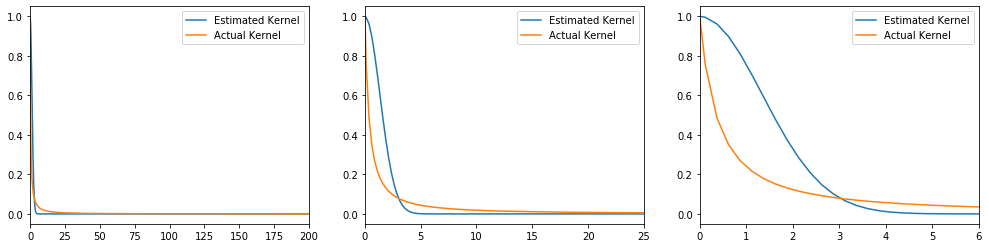

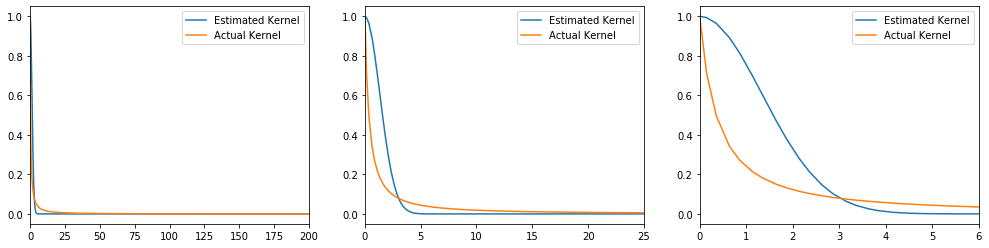

In [166]:
## Moving Average


alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
actual_alpha = power_law_kernel(np.array(t))
actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

ax1.plot(t,alpha,label='Estimated Kernel')
ax1.plot(t,actual_alpha,label='Actual Kernel')
ax1.set_xlim(0, 200)
ax1.legend()

ax2.plot(t,alpha,label='Estimated Kernel')
ax2.plot(t,actual_alpha,label='Actual Kernel')
ax2.set_xlim(0, 25)
ax2.legend()


ax3.plot(t,alpha,label='Estimated Kernel')
ax3.plot(t,actual_alpha,label='Actual Kernel')
ax3.set_xlim(0, 6)
ax3.legend()

plt.show()

## Event Predictions

### RMSE Calculations

In [167]:
last_errors = []
all_errors = []
all_predictions = []
all_arrivals = []
for batch in testloader:
    

    event_type = batch[2]
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)

    
    predicted_times = model(event_type,event_time)


    last_event_index = event_type.sum(-1)-2
    errors = predicted_times[:, :-1] - arrival_time[:, 1:]
    seq_index = 0
    for idx in last_event_index:
        last_errors.append(errors[seq_index][idx].unsqueeze(-1))
        all_errors.append(errors[seq_index][:idx+1])
        all_predictions.append(predicted_times[:, :-1][:idx+1].squeeze(0))
        all_arrivals.append(arrival_time[:, :-1][:idx+1].squeeze(0))
last_errors = torch.cat(last_errors)
last_RMSE =(last_errors**2).mean().sqrt()

all_predictions = torch.cat(all_predictions)
all_arrivals = torch.cat(all_arrivals)


all_errors = torch.cat(all_errors)
all_RMSE = (all_errors**2).mean().sqrt()



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking arugment for argument index in method wrapper_index_select)

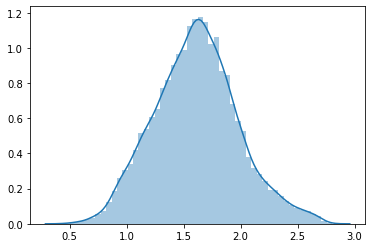

In [8]:
sns.distplot(all_predictions.cpu().detach())

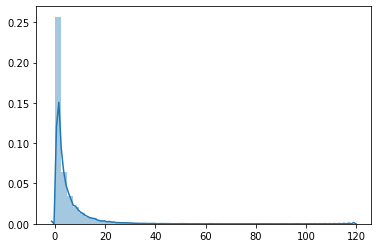

In [9]:
sns.distplot(all_arrivals.cpu().detach())

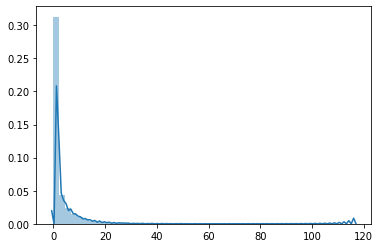

In [10]:
sns.distplot(np.abs(all_errors.to('cpu').detach()))

In [ ]:
(tensor(0.2037, grad_fn=<SelectBackward>),
 tensor(0.6250, grad_fn=<SelectBackward>))

## Sin Hawkes

In [16]:
data = '../data/simulated/sin_hawkes/'
batch_size = 1
def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)

train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')


trainloader = get_dataloader(train_data, batch_size, shuffle=True)
testloader = get_dataloader(test_data, 1, shuffle=False)
valloader = get_dataloader(dev_data, 1, shuffle=False)

t_max = max(max(max(valloader.dataset.time)), max(max(testloader.dataset.time)), max(max(trainloader.dataset.time)))

model = gated_TPP(num_types,32, t_max=t_max,dropout= 0.1)
device = 'cuda'
model.load_state_dict(torch.load('trained_models/sin_hawkesdebug_model.pt'))

<All keys matched successfully>

In [17]:
model.encoder.kernel.length_scale(model.encoder.type_emb.weight)[-1]

tensor([2.2018], grad_fn=<SelectBackward>)

In [18]:
model.encoder.sigmoid.params(model.encoder.type_emb.weight)[-1]

tensor([0.9698, 0.0782], grad_fn=<SelectBackward>)

In [19]:
kernel_values = []
all_times = []

model = model.to(device)

for batch in testloader:
    
    event_type = batch[2]
    length = event_type.sum()
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)
    scores, embedding,t_diff = model.encoder(event_type,event_time)
    scores = model.encoder.scores

    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]
    
    kernel_values.append(triggering_values.detach())
    all_times.append(times.detach())
    
kernel_values = torch.cat(kernel_values)
all_times = torch.cat(all_times)

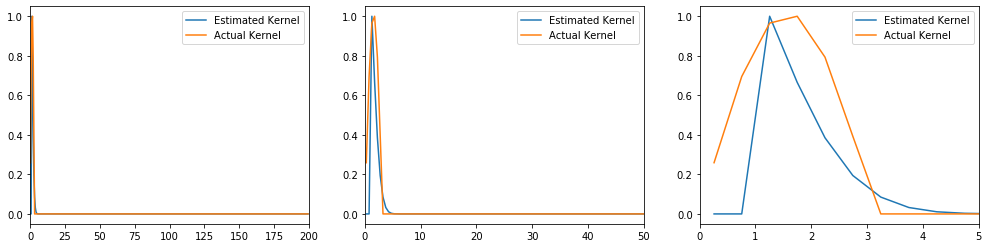

In [32]:
x = all_times.detach()
y = kernel_values.detach()

sorted_indices = torch.argsort(x)

x = x[sorted_indices]
y = y[sorted_indices]


def sin_kernel(t):
    

    t_c = np.copy(t)
    t_c[t_c>4] =0
    sin = np.sin(t_c)/8
    sin[sin <0] =0
    return sin


## Moving Average

step = 0.5

t = []
alpha = []

for i in np.arange(step,200,step):
    avg_index = (x<i) & ( x >i - step)
    t.append(x[avg_index].mean().item())
    alpha.append(y[avg_index].mean().item())
alpha = np.array(alpha)
alpha = alpha/alpha.max()
actual_alpha = sin_kernel(np.array(t))
actual_alpha = (actual_alpha - actual_alpha.min())/(actual_alpha.max()-actual_alpha.min())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,4))

ax1.plot(t,alpha,label='Estimated Kernel')
ax1.plot(t,actual_alpha,label='Actual Kernel')
ax1.set_xlim(0, 200)
ax1.legend()

ax2.plot(t,alpha,label='Estimated Kernel')
ax2.plot(t,actual_alpha,label='Actual Kernel')
ax2.set_xlim(0, 50)
ax2.legend()


ax3.plot(t,alpha,label='Estimated Kernel')
ax3.plot(t,actual_alpha,label='Actual Kernel')
ax3.set_xlim(0, 5)
ax3.legend()

plt.show()

In [31]:
alpha.max()

1.2903988361358643

In [40]:
last_errors = []
all_errors = []
all_predictions = []
all_arrivals = []
for batch in testloader:
    

    event_type = batch[2]
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)

    
    predicted_times = model(event_type,event_time)


    last_event_index = event_type.sum(-1)-2
    errors = predicted_times[:, :-1] - arrival_time[:, 1:]
    seq_index = 0
    for idx in last_event_index:
        last_errors.append(errors[seq_index][idx].unsqueeze(-1))
        all_errors.append(errors[seq_index][:idx+1])
        all_predictions.append(predicted_times[:, :-1][:idx+1].squeeze(0))
        all_arrivals.append(arrival_time[:, :-1][:idx+1].squeeze(0))
last_errors = torch.cat(last_errors)
last_RMSE =(last_errors**2).mean().sqrt()

all_predictions = torch.cat(all_predictions)
all_arrivals = torch.cat(all_arrivals)


all_errors = torch.cat(all_errors)
all_RMSE = (all_errors**2).mean().sqrt()



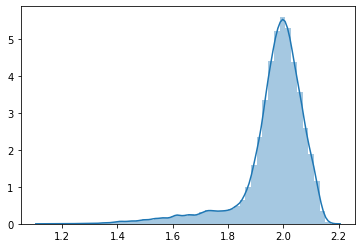

In [41]:
sns.distplot(all_predictions.cpu().detach())

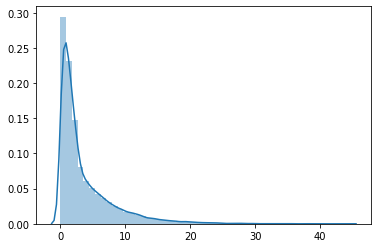

In [42]:
sns.distplot(all_arrivals.cpu().detach())

## Gate Experiments

In [ ]:
nn.ModuleList([nn.Parameter(),nn.Parameter()])

In [51]:
val_s

tensor([1.0000, 1.0000, 1.0000,  ..., 2.9397, 2.9406, 2.9415])

In [ ]:
nn.Parameter(torch.tensor(-0.1))

In [ ]:
nn.Sequential(nn.Parameter(torch.tensor([ 0.1] )), nn.Softplus())

In [ ]:
torch.softplus

In [13]:

def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =2):
    d = x**norm
    return 1+torch.tanh((d-l)/s)



C:\Users\yamac\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


(0, 4)

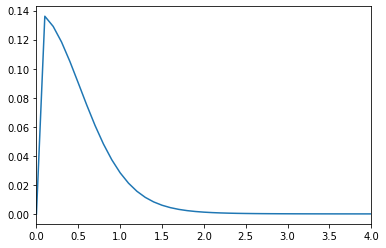

In [16]:
t =torch.arange(0,200,0.1)
val = squared_exponential_kernel(t,sigma = 2,lambd=2.1269,norm = 1)
val_s = sigmoid((t/200),l =0.000001,s= 0.000000111,norm =1)

plt.plot(t,F.softmax(val_s*val))
plt.xlim(0, 4)


In [31]:
def sig(d,l,s):
    return 1+0.5*torch.tanh((d - l) / s)

In [32]:
t = torch.arange(0,200,0.1)

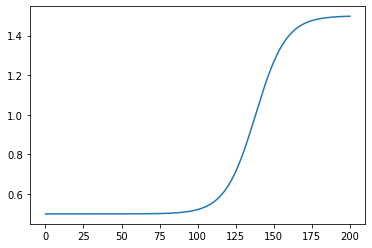

In [33]:
values = sig(t/200,0.6900,0.1)
plt.plot(t,values)

In [34]:
values

tensor([0.5000, 0.5000, 0.5000,  ..., 1.4979, 1.4979, 1.4980])